# Introduccion
En este trabajo buscar generar un modelo para estudiar in silico la presencia de un tipo particular de motivo de unión a la proteina VCP. 
VCP (Transitional endoplasmic reticulum ATPase (TER ATPase) también conocida como valosin-containing protein (VCP)) es una ATPasa asociada con diversas actividades celulares altamente conservada desde arqueobacterias hasta eucariotas. Es responsable de la segregación de polipéptidos de estructuras celulares tales como ensamblados proteicos, membranas y ribosomas, entre otras, facilitando su degradación por proteosoma. Esta actividad es esencial para la fisiología celular, y mutaciones de esta proteína han sido asociadas a distintas patologías humanas, tales como cáncer y desórdenes neurodegenerativos. La actividad de VCP está altamente regulada por la unión de diversos co-factores que modulan entre otras cosas su localización celular y su especificidad de unión a sustratos. En particular analizaremos un motivo llamado VIM (VCP interacting motif) que interactúa con la región N terminal de VCP.
Para poder generar este modelo se tienen dos estructuras cristalizadas de VCP unida a dos secuencias VIM de dos proteinas (las estructuras pueden encontrarse en el Protein Data Bank (https://www.rcsb.org/) con los codigos 3TIW y 5KIW. Mediante el paquete FoldX se generaron in silico modelos de distintos peptidos en unión a VCP utilizando como base estas estructuras cristalizadas y a partir de los mismos se derivaron parametros asociados.
Poseemos algunas secuencias de unión probada que utilizaremos de positivos y como negativos utilizaremos secuencias aleatorias generadas. 
Además se tienen algunas secuencias candidatas obtenidas del proteoma humano por similitud de secuencias al modelo oculto de Markov generado por alineamiento de las secuencias de unión probada.
Por otro lado tambien existen, derivadas de un enfoque mas sencillo que no se detallará, una serie de secuencias que se denominaran "estables" que presentan valores de energia libre bajos pero que no presentan una secuencia que se asemeje a un VIM. Estas secuencias sugieren que utilizar la energia libre como unico parametro de estudio sería erroneo y en cambio se necesita de un campo mayor para poder discernir VIMs de no VIMs. Bajo esa premisa se realizó el siguiente trabajo:



In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import math
import csv
import time
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import sklearn.preprocessing as pp
from sklearn.svm import SVC
from math import exp
seed = 7122020 #seed de la fecha para reproducibilidad
random.seed(seed) 

In [27]:
"""Cargamos todos los .fxout como dataframes
Estos archivos son los que salen de FoldX y en algunos casos se agrego la columna "VIM" que indica si la secuencia es (1) 
o no (-1) un VIM.
"""
def cargar_datos():
    %cd F:\Vims_nuevos
    global tiw, kiw, tiw_cands, kiw_cands, tiw_puntajes, kiw_puntajes, tiw_solo_cands, kiw_solo_cands, tiw_todas, kiw_todas
    tiw = pd.read_csv("Dif_3tiw_ACONLY_Repair.fxout", sep='\t') # Positivos y negativos con la estructura 3TIW
    kiw = pd.read_csv("Dif_5kiw_ACONLY_Repair.fxout", sep='\t') # Positivos y negativos con la estructura 5KIW
    tiw_cands = pd.read_csv("Dif_3tiw_ACONLY_Repair_cands.fxout", sep='\t') # Positivos, negativos y candidatas con la estructura 3TIW
    kiw_cands = pd.read_csv("Dif_5kiw_ACONLY_Repair_cands.fxout", sep='\t') # Positivos, negativos y candidatas con la estructura 5KIW
    tiw_solo_cands = pd.read_csv("Dif_3tiw_ACONLY_candidatas.fxout", sep='\t') # Candidatas con la estructura 3TIW
    kiw_solo_cands = pd.read_csv("Dif_5kiw_ACONLY_candidatas.fxout", sep='\t') # Candidatas con la estructura 5KIW
    tiw_puntajes = pd.read_csv("Dif_3tiw_ACONLY_buenos_puntajes.fxout", sep='\t') # Estables con la estructura 3TIW
    kiw_puntajes = pd.read_csv("Dif_5kiw_ACONLY_buenos_puntajes.csv") # Estables con la estructura 5KIW
    tiw_todas = pd.read_csv("Dif_3tiw_ACONLY_TODAS.fxout", sep='\t') # Positivos, negativos, candidatas y estables con la estructura 3TIW
    kiw_todas = pd.read_csv("Dif_5kiw_ACONLY_TODAS.fxout", sep='\t') # Positivos, negativos, candidatas y estables con la estructura 5KIW
cargar_datos()


F:\Vims_nuevos


In [28]:
"""Saco algunas columnas que no vamos a usar
Porque las saco? principalmente porque no nos aportan informacion, como por ejemplo el parametro "disulfide" que 
indica si la estructura presenta cierto tipo de union conocida como puente disulfuro, para que esta union se produzca se necesitan
dos aminoacidos cisteina, como en la region de union de VCP al VIM no hay cisteinas este parametro sera siempre cero y no es informativo
"""
Columnas_a_sacar =['Pdb', 'water bridge', "sloop_entropy", "mloop_entropy", "cis_bond", 'disulfide', 'partial covalent bonds'
, 'energy Ionisation', 'Entropy Complex']
lista_csvs = [tiw, kiw, tiw_cands, kiw_cands, tiw_puntajes, kiw_puntajes, tiw_solo_cands, kiw_solo_cands, tiw_todas, kiw_todas]
for i in Columnas_a_sacar:
  for j in lista_csvs:
    j.drop(i, axis='columns', inplace=True)

In [29]:
#Genero matrices de correlacion con respecto a la columna VIM que es 1 si la secuencia presenta un VIM y -1 si no.
corr_matrix = tiw.corr()
print("tiw")
print(corr_matrix["VIM"].sort_values(ascending=False))
corr_matrix = kiw.corr()
print()
print("kiw")
print(corr_matrix["VIM"].sort_values(ascending=False))


tiw
VIM                      1.000000
backbone clash           0.281603
entropy sidechain        0.228696
Solvation Hydrophobic    0.127232
Solvation Polar          0.068534
Van der Waals           -0.008504
helix dipole            -0.068269
Sidechain Hbond         -0.187958
Backbone Hbond          -0.203813
torsional clash         -0.372526
Van der Waals clashes   -0.506746
entropy mainchain       -0.518419
electrostatic kon       -0.630013
total energy            -0.694950
Electrostatics          -0.740678
Name: VIM, dtype: float64

kiw
VIM                      1.000000
entropy sidechain        0.109552
helix dipole             0.107160
Van der Waals            0.074359
backbone clash           0.069393
Solvation Hydrophobic    0.054044
Sidechain Hbond          0.021843
Solvation Polar         -0.072620
Electrostatics          -0.225067
Backbone Hbond          -0.237260
Van der Waals clashes   -0.262778
torsional clash         -0.316315
electrostatic kon       -0.421033
total energy 

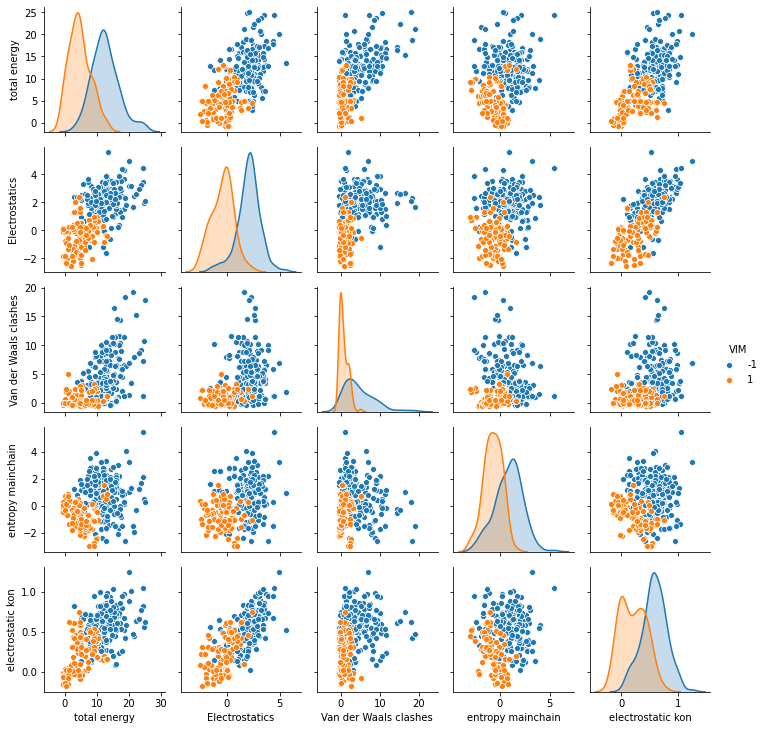

In [30]:
#Quito las columnas de baja correlacion.
Colummas_de_baja_correlacion = ["backbone clash","entropy sidechain","Solvation Hydrophobic","Solvation Polar","Van der Waals"
                                ,"helix dipole","Backbone Hbond","Sidechain Hbond","torsional clash"]
lista_tiws = [tiw, tiw_cands, tiw_puntajes, tiw_solo_cands, tiw_todas]
for i in Colummas_de_baja_correlacion:
    for j in lista_tiws:
      j.drop(i,axis='columns', inplace=True)
sns.pairplot(tiw,hue="VIM", height = 2)

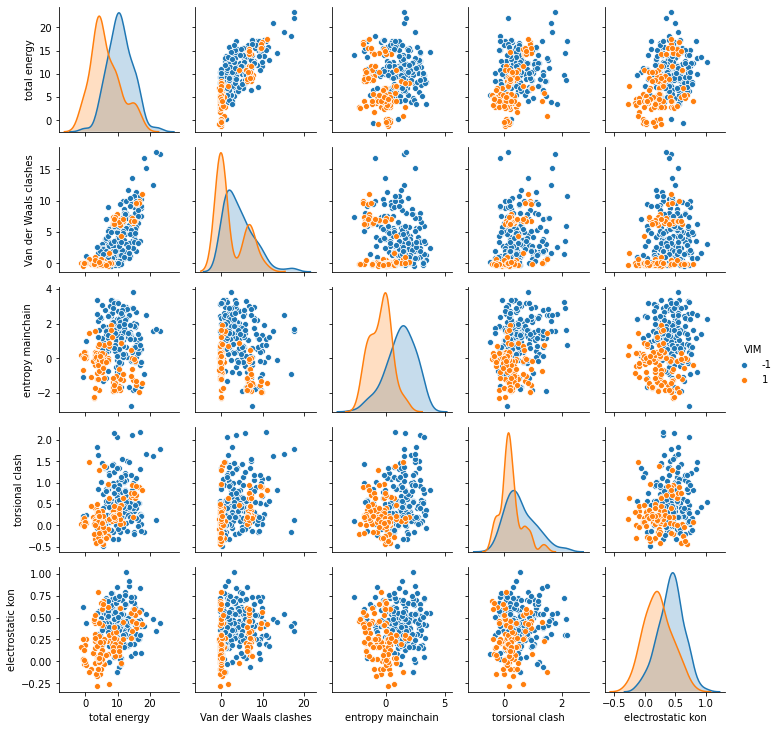

In [31]:
Colummas_de_baja_correlacion = ["backbone clash","entropy sidechain","Solvation Hydrophobic","Solvation Polar","Van der Waals"
                                ,"helix dipole","Backbone Hbond","Sidechain Hbond", "Electrostatics" ]
lista_tiws = [kiw, kiw_cands, kiw_puntajes, kiw_solo_cands, kiw_todas]
for i in Colummas_de_baja_correlacion:
    for j in lista_tiws:
      j.drop(i,axis='columns', inplace=True)
sns.pairplot(kiw,hue="VIM", height = 2)

Claramente este segundo grupo parece mas dificil de separar, ya que para varios parametros la poblacion de positivos es hoterogenea, especialmente para los choques de Van der Waals.
Comparemos las 4 poblaciones que poseemos ( positivas, negativas, incognitas y estables).

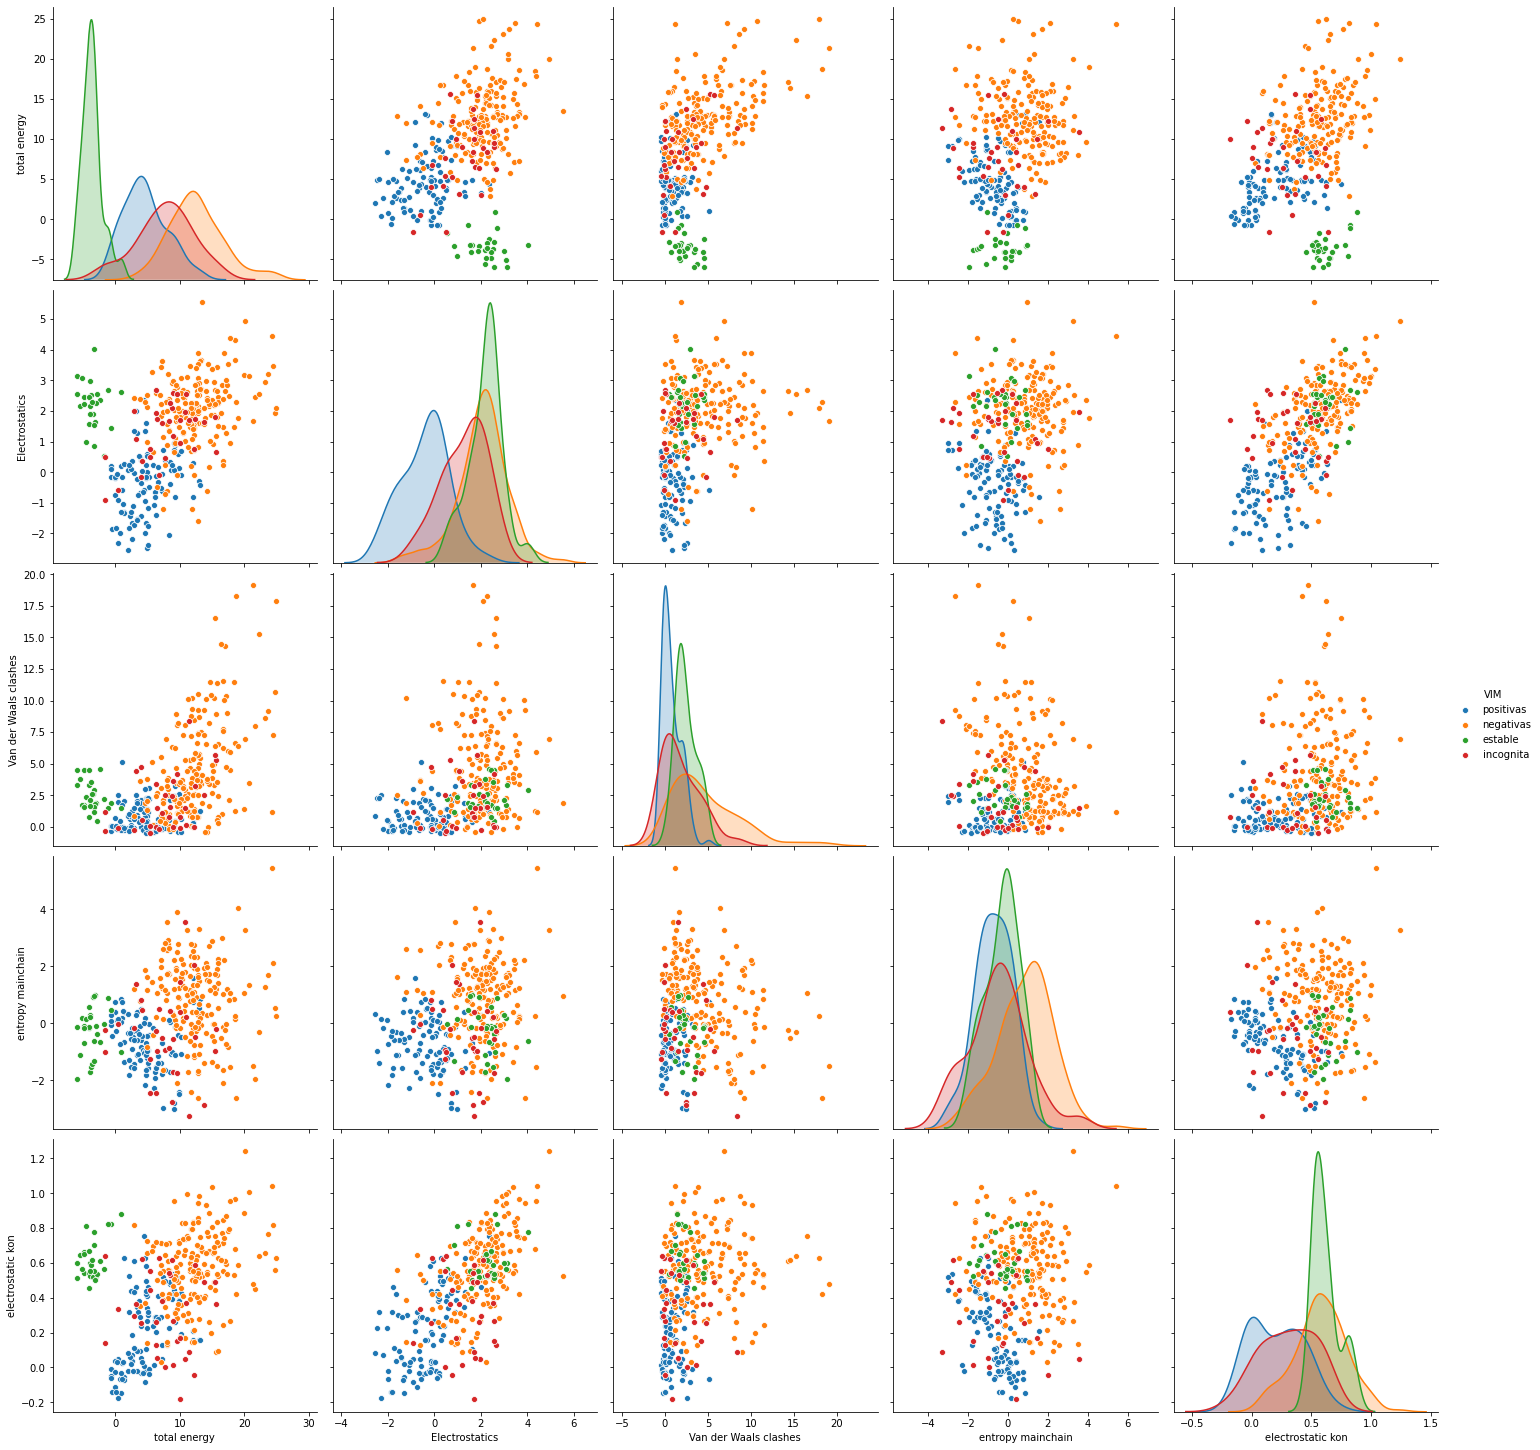

In [32]:

sns.pairplot(tiw_todas,hue="VIM", height = 4)

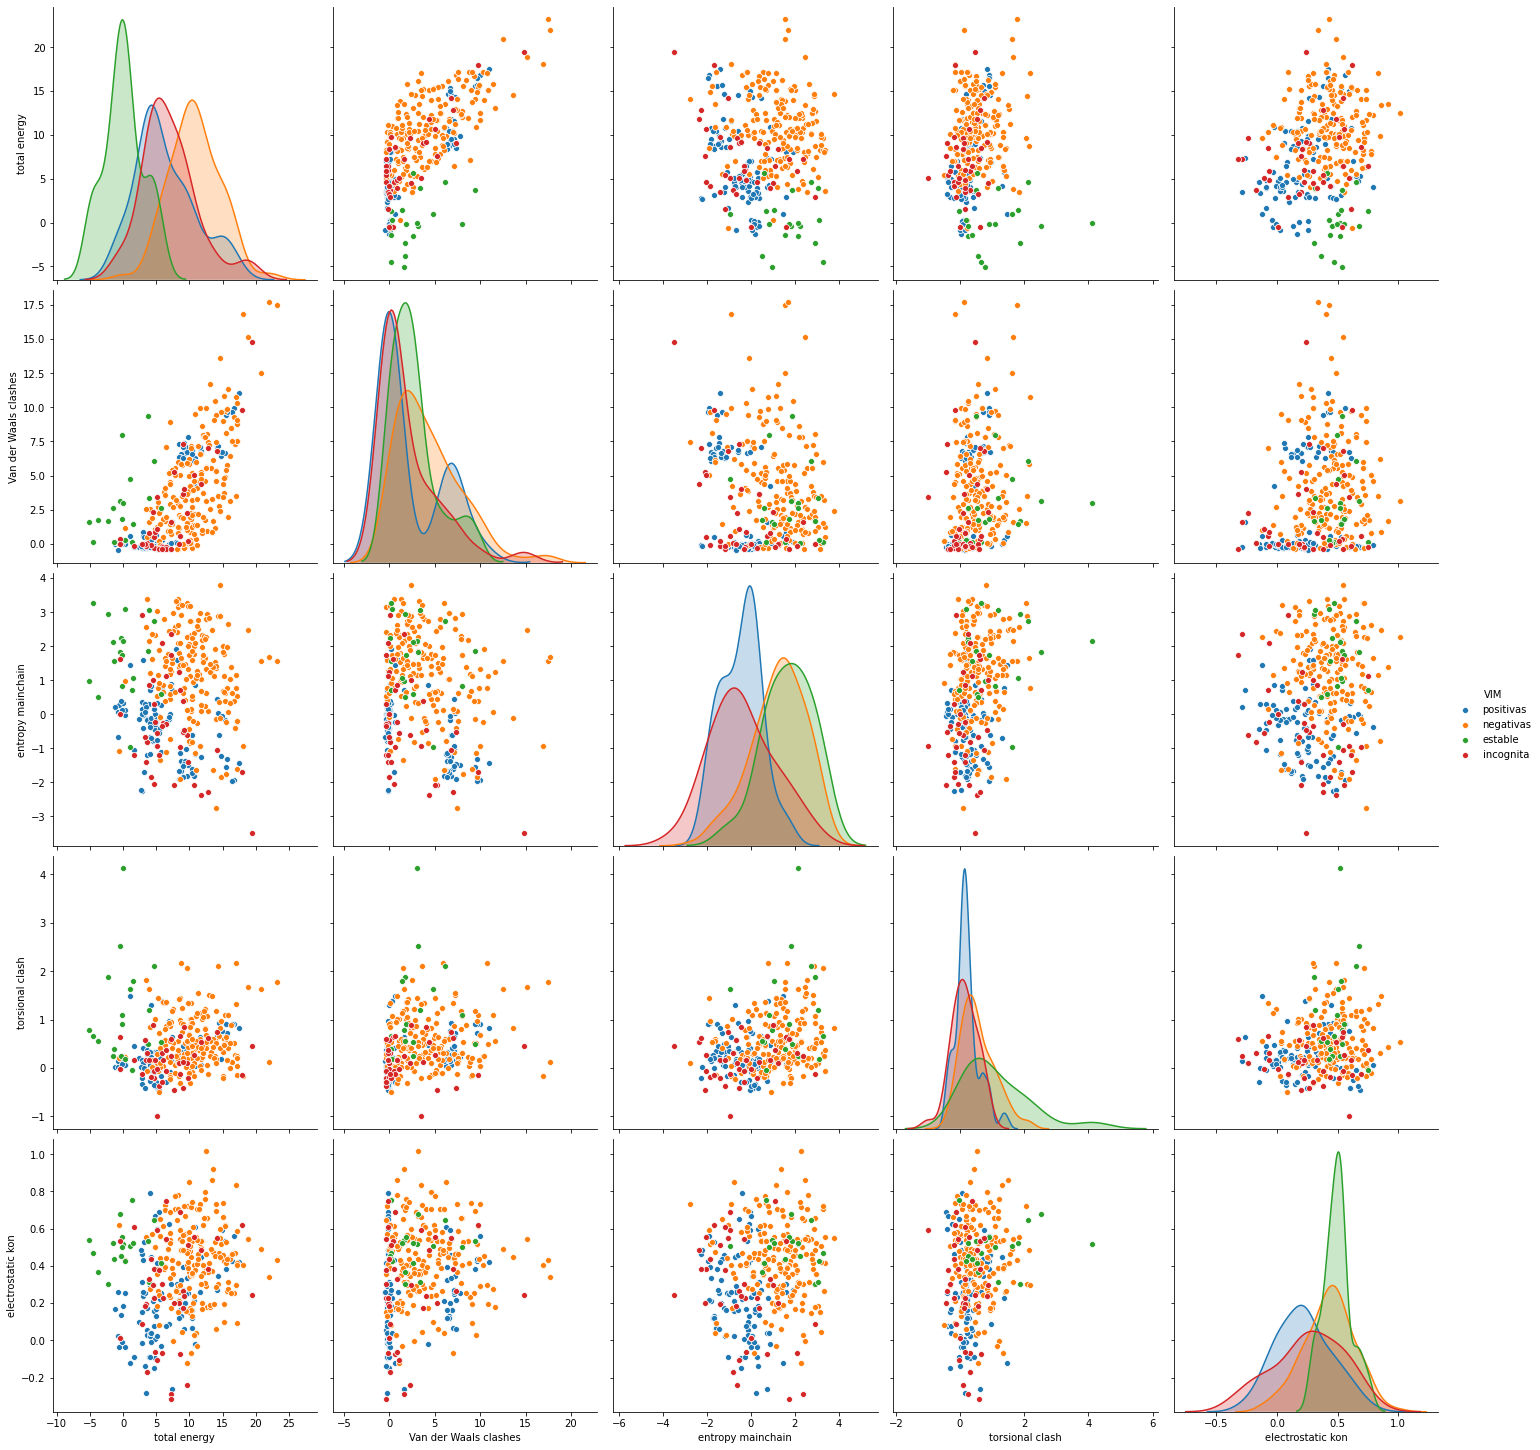

In [33]:
sns.pairplot(kiw_todas,hue="VIM", height = 4)

Si bien se pueden distinguir algunas tendencias no es claro a simple vista que se puedan separar las poblaciones, tal vez en un espacio que comprenda los 5 parametros (en lugar de verlos de a pares) se pueda encontrar una forma, para eso tomaremos los siguientes enfoques:   
·Random Forest  
·svm  



In [34]:
#Separo en conjuntos de test y entrenamiento

X_tiw_train, X_tiw_test, t_tiw_train, t_tiw_test = train_test_split(tiw.drop("VIM", axis=1), tiw["VIM"], test_size=0.20)
X_kiw_train, X_kiw_test, t_kiw_train, t_kiw_test = train_test_split(kiw.drop("VIM", axis=1), kiw["VIM"], test_size=0.20)

In [35]:
#Random Forests
pipeline = Pipeline([
        ("scaler", StandardScaler()), 
        ("rd_forest", RandomForestClassifier(random_state = seed))])                      
parametros_tiw = {'rd_forest__max_depth':[4,5,6,7], "rd_forest__max_leaf_nodes":[350, 400, 450, 500], "rd_forest__n_estimators":[500]}

rf_gridtiw = GridSearchCV(pipeline, parametros_tiw, cv=20, refit=True)
rf_gridtiw.fit(X_tiw_train, t_tiw_train) 
print('Best score: ',rf_gridtiw.best_score_, rf_gridtiw.best_params_)


parametros_kiw = {'rd_forest__max_depth':[5,6,7,8], "rd_forest__max_leaf_nodes":[300, 350, 400, 450], "rd_forest__n_estimators":[500]}

rf_gridkiw = GridSearchCV(pipeline, parametros_kiw, cv=20, refit=True)
rf_gridkiw.fit(X_kiw_train, t_kiw_train) 
print('Best score: ',rf_gridkiw.best_score_, rf_gridkiw.best_params_)

Best score:  0.9738636363636364 {'rd_forest__max_depth': 4, 'rd_forest__max_leaf_nodes': 350, 'rd_forest__n_estimators': 500}
Best score:  0.8969696969696969 {'rd_forest__max_depth': 7, 'rd_forest__max_leaf_nodes': 300, 'rd_forest__n_estimators': 500}


In [36]:
#Vemos como dan los resultados en el conjunto de entrenamiento
confusio_tiw=confusion_matrix(t_tiw_train,rf_gridtiw.predict(X_tiw_train))
print("RF hecho con tiw")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_tiw[0])
print("pos", confusio_tiw[1])
tn, fp, fn, tp = confusio_tiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))
print()
confusio_kiw=confusion_matrix(t_kiw_train,rf_gridkiw.predict(X_kiw_train))
print("RF hecho con kiw")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_kiw[0])
print("pos", confusio_kiw[1])
tn, fp, fn, tp = confusio_kiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))

RF hecho con tiw
      pn    pp     (pp= predicho positivo, pn= predicho negativo)
neg [149   0]
pos [ 0 77]
Sensitividad (TPR/Recall):   1.000
Especificidad:               1.000
Precision:                   1.000
FPR:                         0.000

RF hecho con kiw
      pn    pp     (pp= predicho positivo, pn= predicho negativo)
neg [155   0]
pos [ 0 77]
Sensitividad (TPR/Recall):   1.000
Especificidad:               1.000
Precision:                   1.000
FPR:                         0.000


In [37]:
#Y lo mismo en el de test
confusio_tiw=confusion_matrix(t_tiw_test,rf_gridtiw.predict(X_tiw_test))
print("RF hecho con tiw")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_tiw[0])
print("pos", confusio_tiw[1])
tn, fp, fn, tp = confusio_tiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))
print()
confusio_kiw=confusion_matrix(t_kiw_test,rf_gridkiw.predict(X_kiw_test))
print("RF hecho con kiw")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_kiw[0])
print("pos", confusio_kiw[1])
tn, fp, fn, tp = confusio_kiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))

RF hecho con tiw
      pn    pp     (pp= predicho positivo, pn= predicho negativo)
neg [35  0]
pos [ 3 19]
Sensitividad (TPR/Recall):   0.864
Especificidad:               1.000
Precision:                   1.000
FPR:                         0.000

RF hecho con kiw
      pn    pp     (pp= predicho positivo, pn= predicho negativo)
neg [34  2]
pos [ 2 20]
Sensitividad (TPR/Recall):   0.909
Especificidad:               0.944
Precision:                   0.909
FPR:                         0.056


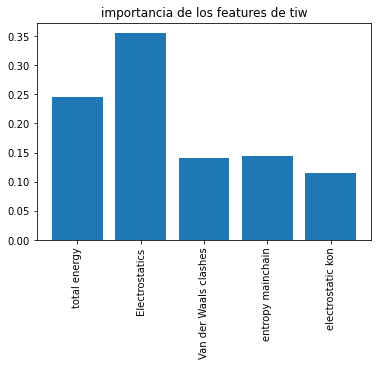

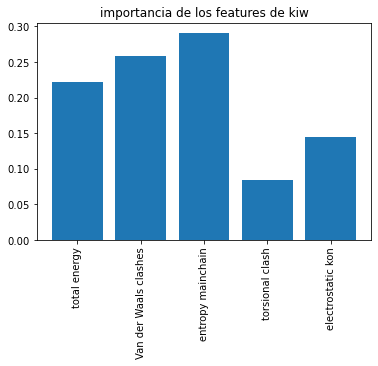

In [38]:
#Graficamos la importancia dada a cada parametro para ver si se correlacionan con lo que esperabamos.


pipelinetiw = Pipeline([
        ("scaler", StandardScaler()), 
        ("rd_forest", RandomForestClassifier(random_state = seed,
                                             max_depth = rf_gridtiw.best_params_["rd_forest__max_depth"],
                                             max_leaf_nodes = rf_gridtiw.best_params_["rd_forest__max_leaf_nodes"],
                                             n_estimators = rf_gridtiw.best_params_["rd_forest__n_estimators"]))])   
pipelinetiw.fit(X_tiw_train, t_tiw_train)
imp = pipelinetiw.named_steps["rd_forest"].feature_importances_.ravel()
plt.bar(list(tiw.drop("VIM", axis=1).columns), imp)
plt.xticks(rotation=90)
plt.title("importancia de los features de tiw")
plt.show()


pipelinekiw = Pipeline([
        ("scaler", StandardScaler()), 
        ("rd_forest", RandomForestClassifier(random_state = seed,
                                             max_depth = rf_gridkiw.best_params_["rd_forest__max_depth"],
                                             max_leaf_nodes = rf_gridkiw.best_params_["rd_forest__max_leaf_nodes"],
                                             n_estimators = rf_gridkiw.best_params_["rd_forest__n_estimators"]))])    
pipelinekiw.fit(X_kiw_train, t_kiw_train)
imp = pipelinekiw.named_steps["rd_forest"].feature_importances_.ravel()
plt.bar(list(kiw.drop("VIM", axis=1).columns), imp)
plt.xticks(rotation=90)
plt.title("importancia de los features de kiw")
plt.show()

Tomamos como criterio que se prediga positivo solo en los casos donde ambos modelos den una probabilidad mayor al 70%.
Queremos quedarnos solo con aquellos casos que tengan una mayor probabilidad de exito, por eso la exigencia impuesta.

In [39]:
positivos = list(zip([j for i,j in rf_gridtiw.predict_proba(tiw[tiw["VIM"] == 1].drop("VIM", axis=1))],
                                                         [j for i,j in rf_gridkiw.predict_proba(kiw[kiw["VIM"] == 1].drop("VIM", axis=1))]))

prediccion_pos = []
n = 0
umbral = 0.7
for i,j in positivos:
    n += 1
    if i > umbral and j > umbral:
        prediccion_pos.append((1))
    else:
        prediccion_pos.append((0))

negativos = list(zip([j for i,j in rf_gridtiw.predict_proba(tiw[tiw["VIM"] == -1].drop("VIM", axis=1))],
                                                         [j for i,j in rf_gridkiw.predict_proba(kiw[kiw["VIM"] == -1].drop("VIM", axis=1))]))

prediccion_neg = []
n = 0
umbral = 0.7
for i,j in negativos:
    n += 1
    if i > umbral and j > umbral:
        prediccion_neg.append((1))
    else:
        prediccion_neg.append((0))


#print(prediccion)
print("recall total: " + str(sum(prediccion_pos)*100/len(prediccion_pos))+ "%")
print("especificidad total: " + str((len(prediccion_neg) - sum(prediccion_neg))*100/len(prediccion_neg)) + "%")

recall total: 86.86868686868686%
especificidad total: 100.0%


In [40]:
#Vemos como dan los candidatos
list(zip(rf_gridtiw.predict(tiw_solo_cands),rf_gridkiw.predict(kiw_solo_cands)))
candidatas = list(zip([j for i,j in rf_gridtiw.predict_proba(tiw_solo_cands)],[j for i,j in rf_gridkiw.predict_proba(kiw_solo_cands)]))
#print(candidatas)
prediccion_cand = []
n = 0
umbral = 0.7
for i,j in candidatas:

    if i > umbral and j > umbral:
        prediccion_cand.append((n,1))
    else:
        prediccion_cand.append((0))
    n += 1
lista_candidatas = ["LRRK2","CUL4B","|Q92508|PIEZ1_HUMAN_1","|Q92508|PIEZ1_HUMAN_2","|P35658|NU214_HUMAN_1","|P35658|NU214_HUMAN_2","|A6NMB1|SIG16_HUMAN_1","|A6NMB1|SIG16_HUMAN_2","|Q9C029|TRIM7_HUMAN","|Q8N8E3|CE112_HUMAN","|Q96EK4|THA11_HUMAN_1","|Q96EK4|THA11_HUMAN_2","|Q96EK4|THA11_HUMAN_3","|Q9NX14|NDUBB_HUMAN_1","|Q9NX14|NDUBB_HUMAN_2","|Q9NX14|NDUBB_HUMAN_3","|Q9NVF7|FBX28_HUMAN","|Q6P575|BGP11_HUMAN","|Q96EA4|SPDLY_HUMAN","|P51955|NEK2_HUMAN","|Q9H840|GEMI7_HUMAN","|Q6UW49|SPESP_HUMAN","|Q96SC8|DMTA2_HUMAN","|Q6UXA7|CF015_HUMAN","|P50570|DYN2_HUMAN","|Q9NR33|DPOE4_HUMAN","|P0CJ78|ZN865_HUMAN","|Q9H213|MAGH1_HUMAN","|Q9NZ72|STMN3_HUMAN","|Q5T440|CAF17_HUMAN","|Q15834|CC85B_HUMAN"]
print("candidatas que pasan este criterio:")
print("     proteina              prediccion tiw  prediccion kiw      promedio")
for l in prediccion_cand:
  if isinstance(l, tuple):
    print("{0:<30s} {1:<15s} {2:<16s} {3:<12s}".format(lista_candidatas[l[0]], str(round(candidatas[l[0]][0],4)), str(round(candidatas[l[0]][1],4)), str(round((candidatas[l[0]][0] + candidatas[l[0]][1])/2,4))))


candidatas que pasan este criterio:
     proteina              prediccion tiw  prediccion kiw      promedio
|Q9NVF7|FBX28_HUMAN            0.9021          0.7502           0.8261      
|P51955|NEK2_HUMAN             0.9895          0.9527           0.9711      


4 proteinas superaron el criterio propuesto siendo NEK2 aquella que mayor probabilidad presenta para estos modelos.

Utilizamos como prueba de concepto aquellas secuencias "estables" que habían sido engañosas en el analisis anterior con un unico parametro. Tenemos cierto grado de seguridad de que estas secuencias no son positivas y asi el modelo generado utilizando como corte un 70% de probabilidad en ambos bosques esta de acuerdo con esto.
Algunas secuencias fueron predichas como positivas por uno de los modelos, por lo que para evitar estos falsos positivos consideramos que es conveniente utilizar ambos modelos en conjunto.

In [41]:
A = list(zip([j for i,j in rf_gridtiw.predict_proba(tiw_puntajes)],[j for i,j in rf_gridkiw.predict_proba(kiw_puntajes)]))
B = []
n = 0
umbral = 0.7
for i,j in A:
    n += 1
    if i > umbral and j > umbral:
        B.append((1))
    else:
        B.append((0))
print("positivos en ambas")
print(B)
C = []
n = 0
for i,j in A:
    n += 1
    if i > umbral or j > umbral:
        C.append((1))
    else:
        C.append((0))
print("positivos en al menos una")
print(C)

positivos en ambas
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
positivos en al menos una
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [42]:
#Que tal si aprovecho la importancia de los features y le bajo un poco mas la dimensionalidad?
Colummas_de_baja_correlacion = ["entropy mainchain", "electrostatic kon"]
lista_tiws = [tiw, tiw_cands, tiw_puntajes, tiw_solo_cands, tiw_todas]
for i in Colummas_de_baja_correlacion:
    for j in lista_tiws:
      j.drop(i,axis='columns', inplace=True)

Colummas_poca_importancia = ["torsional clash", "electrostatic kon"]
lista_tiws = [kiw, kiw_cands, kiw_puntajes, kiw_solo_cands, kiw_todas]
for i in Colummas_poca_importancia:
    for j in lista_tiws:
      j.drop(i,axis='columns', inplace=True)

X_tiw_train, X_tiw_test, t_tiw_train, t_tiw_test = train_test_split(tiw.drop("VIM", axis=1), tiw["VIM"], test_size=0.20)
X_kiw_train, X_kiw_test, t_kiw_train, t_kiw_test = train_test_split(kiw.drop("VIM", axis=1), kiw["VIM"], test_size=0.20)

In [43]:
pipeline = Pipeline([
        ("scaler", StandardScaler()), 
        ("rd_forest", RandomForestClassifier(random_state = seed))])                      
parametros_tiw = {'rd_forest__max_depth':[2,3,4,5], "rd_forest__max_leaf_nodes":[20,50,100,150], "rd_forest__n_estimators":[500]}

rf_gridtiw_menos_parametros = GridSearchCV(pipeline, parametros_tiw, cv=20, refit=True)
rf_gridtiw_menos_parametros.fit(X_tiw_train, t_tiw_train) 
print('Best score TIW: ',rf_gridtiw_menos_parametros.best_score_, rf_gridtiw_menos_parametros.best_params_)


parametros_kiw = {'rd_forest__max_depth':[4,5,6,7], "rd_forest__max_leaf_nodes":[300, 350, 400, 450,500], "rd_forest__n_estimators":[500]}
rf_gridkiw_menos_parametros = GridSearchCV(pipeline, parametros_kiw, cv=20, refit=True)
rf_gridkiw_menos_parametros.fit(X_kiw_train, t_kiw_train) 
print('Best score KIW: ',rf_gridkiw_menos_parametros.best_score_, rf_gridkiw_menos_parametros.best_params_)

Best score TIW:  0.9242424242424242 {'rd_forest__max_depth': 4, 'rd_forest__max_leaf_nodes': 20, 'rd_forest__n_estimators': 500}
Best score KIW:  0.875 {'rd_forest__max_depth': 4, 'rd_forest__max_leaf_nodes': 300, 'rd_forest__n_estimators': 500}


Al bajar la dimensionalidad obtengo un modelo mas sencillo, pero pierdo potencia, dado que nuestro modelo anterior no es complejo no creo que sea necesario este corte

In [44]:
#Recuperemos los datos inciales y su preprocesado..
cargar_datos()
Columnas_a_sacar =['Pdb', 'water bridge', "sloop_entropy", "mloop_entropy", "cis_bond", 'disulfide', 'partial covalent bonds'
, 'energy Ionisation', 'Entropy Complex']
lista_csvs = [tiw, kiw, tiw_cands, kiw_cands, tiw_puntajes, kiw_puntajes, tiw_solo_cands, kiw_solo_cands, tiw_todas, kiw_todas]
for i in Columnas_a_sacar:
  for j in lista_csvs:
    j.drop(i, axis='columns', inplace=True)
    
Colummas_de_baja_correlacion = ["backbone clash","entropy sidechain","Solvation Hydrophobic","Solvation Polar","Van der Waals"
                                ,"helix dipole","Backbone Hbond","Sidechain Hbond", "Electrostatics" ]
lista_tiws = [kiw, kiw_cands, kiw_puntajes, kiw_solo_cands, kiw_todas]
for i in Colummas_de_baja_correlacion:
    for j in lista_tiws:
      j.drop(i,axis='columns', inplace=True)

Colummas_de_baja_correlacion = ["backbone clash","entropy sidechain","Solvation Hydrophobic","Solvation Polar","Van der Waals"
                                ,"helix dipole","Backbone Hbond","Sidechain Hbond","torsional clash"]
lista_tiws = [tiw, tiw_cands, tiw_puntajes, tiw_solo_cands, tiw_todas]
for i in Colummas_de_baja_correlacion:
    for j in lista_tiws:
      j.drop(i,axis='columns', inplace=True)
    
X_tiw_train, X_tiw_test, t_tiw_train, t_tiw_test = train_test_split(tiw.drop("VIM", axis=1), tiw["VIM"], test_size=0.20)
X_kiw_train, X_kiw_test, t_kiw_train, t_kiw_test = train_test_split(kiw.drop("VIM", axis=1), kiw["VIM"], test_size=0.20)

F:\Vims_nuevos


In [45]:
#Y probemos como se llevan los datos con una svm
svm_clf = Pipeline([
        ("poly_features", pp.PolynomialFeatures()),
        ("scaler", pp.StandardScaler()),
        ("svm_clf", SVC(probability = True, random_state = seed))
    ])
parametros_tiw = {'svm_clf__C':[exp(x) for x in np.linspace(-1,2,10)], "svm_clf__gamma":[exp(x) for x in np.linspace(-7,0,10)], "svm_clf__kernel":["rbf", "sigmoid", "linear"]}
svm_gridtiw = GridSearchCV(svm_clf, parametros_tiw, cv=20, refit=True)
svm_gridtiw.fit(X_tiw_train, t_tiw_train)
print('Best score TIW: ',svm_gridtiw.best_score_, svm_gridtiw.best_params_)
parametros_kiw = {'svm_clf__C':[exp(x) for x in np.linspace(-1,2,20)], "svm_clf__gamma":[exp(x) for x in np.linspace(-7,0,20)], "svm_clf__kernel":["rbf", "sigmoid", "linear"]}

svm_gridkiw = GridSearchCV(svm_clf, parametros_kiw, cv=20, refit=True)
svm_gridkiw.fit(X_kiw_train, t_kiw_train)
print('Best score KIW: ',svm_gridkiw.best_score_, svm_gridkiw.best_params_)

Best score TIW:  0.9821969696969697 {'svm_clf__C': 1.0, 'svm_clf__gamma': 0.4594258240359267, 'svm_clf__kernel': 'rbf'}
Best score KIW:  0.9314393939393939 {'svm_clf__C': 2.446691838462353, 'svm_clf__gamma': 0.2290799498154876, 'svm_clf__kernel': 'rbf'}


In [46]:
#Vemos como dan los resultados en el conjunto de entrenamiento
confusio_tiw=confusion_matrix(t_tiw_train,svm_gridtiw.predict(X_tiw_train))
print("SVM hecho con tiw (train)")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_tiw[0])
print("pos", confusio_tiw[1])
tn, fp, fn, tp = confusio_tiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))
print()
confusio_kiw=confusion_matrix(t_kiw_train,svm_gridkiw.predict(X_kiw_train))
print("SVM hecho con kiw (train)")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_kiw[0])
print("pos", confusio_kiw[1])
tn, fp, fn, tp = confusio_kiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))

SVM hecho con tiw (train)
      pn    pp     (pp= predicho positivo, pn= predicho negativo)
neg [144   0]
pos [ 0 82]
Sensitividad (TPR/Recall):   1.000
Especificidad:               1.000
Precision:                   1.000
FPR:                         0.000

SVM hecho con kiw (train)
      pn    pp     (pp= predicho positivo, pn= predicho negativo)
neg [147   1]
pos [ 0 84]
Sensitividad (TPR/Recall):   1.000
Especificidad:               0.993
Precision:                   0.988
FPR:                         0.007


In [47]:
#Y con el conjunto de test..
confusio_tiw=confusion_matrix(t_tiw_test,svm_gridtiw.predict(X_tiw_test))
print("SVM hecho con tiw (test)")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_tiw[0])
print("pos", confusio_tiw[1])
tn, fp, fn, tp = confusio_tiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))
print()

confusio_tiw=confusion_matrix(t_kiw_test,svm_gridkiw.predict(X_kiw_test))
print("SVM hecho con kiw (test)")
print("      pn    pp     (pp= predicho positivo, pn= predicho negativo)")
print("neg", confusio_tiw[0])
print("pos", confusio_tiw[1])
tn, fp, fn, tp = confusio_tiw.ravel()
print("Sensitividad (TPR/Recall):%8.3f" % (tp/(tp+fn)))
print("Especificidad:%20.3f" % (tn/(tn+fp)))
print("Precision:%24.3f" % (tp/(tp+fp)))
print("FPR:%30.3f" % (fp/(tn+fp)))
print()

SVM hecho con tiw (test)
      pn    pp     (pp= predicho positivo, pn= predicho negativo)
neg [40  0]
pos [ 0 17]
Sensitividad (TPR/Recall):   1.000
Especificidad:               1.000
Precision:                   1.000
FPR:                         0.000

SVM hecho con kiw (test)
      pn    pp     (pp= predicho positivo, pn= predicho negativo)
neg [39  4]
pos [ 2 13]
Sensitividad (TPR/Recall):   0.867
Especificidad:               0.907
Precision:                   0.765
FPR:                         0.093



Tomamos como criterio que se prediga positivo solo en los casos donde ambos modelos den una probabilidad mayor al 70%.
Queremos quedarnos solo con aquellos casos que tengan una mayor probabilidad de exito, por eso la exigencia impuesta.

In [48]:

positivos = list(zip([j for i,j in svm_gridtiw.predict_proba(tiw[tiw["VIM"] == 1].drop("VIM", axis=1))],
                                                         [j for i,j in svm_gridkiw.predict_proba(kiw[kiw["VIM"] == 1].drop("VIM", axis=1))]))
#print(positivos)
prediccion_pos = []
n = 0
umbral = 0.7
for i,j in positivos:
    n += 1
    if i > umbral and j > umbral:
        prediccion_pos.append((1))
    else:
        prediccion_pos.append((0))

negativos = list(zip([j for i,j in svm_gridtiw.predict_proba(tiw[tiw["VIM"] == -1].drop("VIM", axis=1))],
                                                         [j for i,j in svm_gridkiw.predict_proba(kiw[kiw["VIM"] == -1].drop("VIM", axis=1))]))
#print(positivos)
prediccion_neg = []
n = 0
umbral = 0.7
for i,j in negativos:
    n += 1
    if i > umbral and j > umbral:
        prediccion_neg.append((1))
    else:
        prediccion_neg.append((0))


#print(prediccion)
print("recall total: " + str(sum(prediccion_pos)*100/len(prediccion_pos))+ "%")
print("especificidad total: " + str((len(prediccion_neg) - sum(prediccion_neg))*100/len(prediccion_neg)) + "%")

recall total: 97.97979797979798%
especificidad total: 100.0%


In [49]:
#Vemos como dan los candidatos
list(zip(svm_gridtiw.predict(tiw_solo_cands),svm_gridkiw.predict(kiw_solo_cands)))
candidatas = list(zip([j for i,j in svm_gridtiw.predict_proba(tiw_solo_cands)],[j for i,j in svm_gridkiw.predict_proba(kiw_solo_cands)]))
#print(candidatas)
prediccion_cand = []
n = 0
umbral = 0.7
for i,j in candidatas:

    if i > umbral and j > umbral:
        prediccion_cand.append((n,1))
    else:
        prediccion_cand.append((0))
    n += 1
lista_candidatas = ["LRRK2","CUL4B","|Q92508|PIEZ1_HUMAN_1","|Q92508|PIEZ1_HUMAN_2","|P35658|NU214_HUMAN_1","|P35658|NU214_HUMAN_2","|A6NMB1|SIG16_HUMAN_1","|A6NMB1|SIG16_HUMAN_2","|Q9C029|TRIM7_HUMAN","|Q8N8E3|CE112_HUMAN","|Q96EK4|THA11_HUMAN_1","|Q96EK4|THA11_HUMAN_2","|Q96EK4|THA11_HUMAN_3","|Q9NX14|NDUBB_HUMAN_1","|Q9NX14|NDUBB_HUMAN_2","|Q9NX14|NDUBB_HUMAN_3","|Q9NVF7|FBX28_HUMAN","|Q6P575|BGP11_HUMAN","|Q96EA4|SPDLY_HUMAN","|P51955|NEK2_HUMAN","|Q9H840|GEMI7_HUMAN","|Q6UW49|SPESP_HUMAN","|Q96SC8|DMTA2_HUMAN","|Q6UXA7|CF015_HUMAN","|P50570|DYN2_HUMAN","|Q9NR33|DPOE4_HUMAN","|P0CJ78|ZN865_HUMAN","|Q9H213|MAGH1_HUMAN","|Q9NZ72|STMN3_HUMAN","|Q5T440|CAF17_HUMAN","|Q15834|CC85B_HUMAN"]
print("candidatas que pasan este criterio:")
print("     proteina              prediccion tiw  prediccion kiw      promedio")
for l in prediccion_cand:
  if isinstance(l, tuple):
    print("{0:<30s} {1:<15s} {2:<16s} {3:<12s}".format(lista_candidatas[l[0]], str(round(candidatas[l[0]][0],4)), str(round(candidatas[l[0]][1],4)), str(round((candidatas[l[0]][0] + candidatas[l[0]][1])/2,4))))


candidatas que pasan este criterio:
     proteina              prediccion tiw  prediccion kiw      promedio
|P35658|NU214_HUMAN_2          1.0             0.9351           0.9675      
|Q96EK4|THA11_HUMAN_1          0.9439          0.9928           0.9683      
|Q96EK4|THA11_HUMAN_2          0.99            0.7349           0.8625      
|Q9NVF7|FBX28_HUMAN            1.0             0.836            0.918       
|P51955|NEK2_HUMAN             0.9945          0.9913           0.9929      
|Q6UW49|SPESP_HUMAN            0.9909          0.9166           0.9537      
|P0CJ78|ZN865_HUMAN            0.9363          0.7487           0.8425      
|Q9NZ72|STMN3_HUMAN            0.9864          0.9634           0.9749      


Este modelo recupera algunas de las proteinas que recupera el modelo anterior y otras. NEK2 tambien es el candidato más probable segun este modelo pero en este caso los candidatos presentan probabilidades mas similares.

In [50]:
list(zip(svm_gridtiw.predict(tiw_puntajes),svm_gridkiw.predict(kiw_puntajes)))
A = list(zip([j for i,j in svm_gridtiw.predict_proba(tiw_puntajes)],[j for i,j in svm_gridkiw.predict_proba(kiw_puntajes)]))
B = []
n = 0
umbral = 0.7
for i,j in A:
    n += 1
    if i > umbral and j > umbral:
        B.append((1))
    else:
        B.append((0))
print("positivos en ambas")
print(B)
C = []
n = 0
for i,j in A:
    n += 1
    if i > umbral or j > umbral:
        C.append((1))
    else:
        C.append((0))
print("positivos en al menos una")
print(C)

positivos en ambas
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
positivos en al menos una
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


En este caso en ninguno de los dos modelos ninguna de estas proteinas "estables" se toma como positiva. Es posible que se pudiese bajar el umbral propuesto para este caso.

Luego de una busqueda bibliografica encontramos que NEK2, la proteina mejor punteada por ambos modelos, se encuentra involucrada en degradación proteasomal por vías aún no descritas por lo cual sería compatible con que sea un interactor de VCP y que actua a este nivel. 

# Conclusiones
Se compararon dos estrategias para la generacion de un modelo probabilístico para la unión de ciertas proteinas candidatas con VCP por medio del sitio de unión VIM.  
Algunos de los candidatos analizados superaron los criterios establecidos para ambos modelos y en particular la proteína NEK2 presento los mejores puntajes para ambos modelos generados.  
Se evalua la posibilidad de testear interaccion entre NEK2 y VCP experimentalmente.
FoldX posee un paquete llamado PepX que podria ser mas acorde a lo que se busca en este trabajo como datos iniciales, a futuro se replicara este trabajo utilizando PepX y se compararan los resultados de ambos.